NAME_1: Marco <br>
LAST-NAME_1: Introvigne <br>
STUDENT-ID_1: 10750466 <br>
NAME_2: Antonio <br>
LAST-NAME_2: Urbano <br>
STUDENT-ID_2: 10527285 <br>
NAME_3: Enrico <br>
LAST-NAME_3: Voltan <br>
STUDENT-ID_3: 10525467 <br>
LEADERBOARD NICKNAME: TLN (Three Little Neurons) <br>

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import numpy as np 
import pandas as pd
import os
import tensorflow as tf

In [ ]:
SEED = 1234
tf.random.set_seed(SEED) 
np.random.seed(SEED)

cwd = os.getcwd()

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Data Augmentation

We first tried to train the network without data augmentation. Then we added most meaningfull parameter according to the dataset taking always in consideration the behaviour in order to avoid overfitting. This final setting is the one which gave us the best result.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_gen = ImageDataGenerator(rotation_range=20,
                                    zoom_range=0.2,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    brightness_range=(0.1,0.4),
                                    horizontal_flip=True,
                                    rescale=1./255)

valid_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
import json
classes = {}
with open('/content/drive/My Drive/Kaggle_1/MaskDataset/train_gt.json') as json_file:
    classes = json.load(json_file)

In [ ]:
dataset_dir = "/content/drive/My Drive/Kaggle_1/MaskDataset/training"
from PIL import Image
df = pd.DataFrame(columns={"name","class"})
classes_names = {
    0:"NOPERSON",
    1:"ALL",
    2:"SOMEONE"
}

for dirname, _, filenames in os.walk(dataset_dir):
    for filename in filenames:
      df2 = pd.DataFrame.from_dict({"name" : [filename], "class" : [classes_names[classes[filename]]]})   
      df = df.append( df2, ignore_index=True)
df

,class,name
0,NOPERSON,16649.jpg
1,NOPERSON,16798.jpg
2,NOPERSON,16613.jpg
3,NOPERSON,16507.jpg
4,NOPERSON,16808.jpg
...,...,...
5609,SOMEONE,10868.jpg
5610,ALL,11316.jpg
5611,SOMEONE,11266.jpg
5612,ALL,11186.jpg


# Configuration

In [ ]:
img_size = 400
batch_size = 16
epochs = 50
num_classes = 3

fine_tuning = True 
up_sampling = False
down_sampling = False
early_stopping = True

# Dataset balancing

We noticed that the dataset is slightly unbalanced, so we have created two functions to equalize it. They are both described in the report.
After some attempts we came up that the best result was obtained with the original dataset.


In [ ]:
n_max = max([len(df[df["class"]==c]) for c in df["class"].unique()])
n_min = min([len(df[df["class"]==c]) for c in df["class"].unique()])

if up_sampling:
  for c in df["class"].unique():
    df = df.append(df[df["class"]==c].sample(n=(n_max-len(df[df["class"]==c]))))
  [len(df[df["class"]==c]) for c in df["class"].unique()]

if down_sampling:
  for c in df["class"].unique():
    df = df.drop(df[df["class"]==c].sample(n=(len(df[df["class"]==c])-n_min)).index)
  [len(df[df["class"]==c]) for c in df["class"].unique()]


[1900, 1900, 1900]

In [ ]:
df

,class,name
0,NOPERSON,16649.jpg
1,NOPERSON,16798.jpg
2,NOPERSON,16613.jpg
3,NOPERSON,16507.jpg
4,NOPERSON,16808.jpg
...,...,...
2191,SOMEONE,13987.jpg
256,SOMEONE,17151.jpg
3335,ALL,12492.jpg
3476,ALL,13002.jpg


We have done crossvalidation splitting the training dataset into training and validation set by keeping the first 5000 images for training and the remaining 614 for validation. We have done tuning on the image size parameter increasing it gradually. When we tried with up sampling we adapted the split accordingly.

In [ ]:
#Validation split
train_size = 5000
if up_sampling:
  train_size = 5200

train_gen = train_data_gen.flow_from_dataframe(df[:train_size],
                                                directory=dataset_dir,
                                                x_col="name",
                                                y_col="class",
                                                target_size=(img_size,img_size),
                                                batch_size=batch_size,
                                                color_mode='rgb',
                                                shuffle=True,
                                                seed=SEED,
                                                save_prefix="",
                                                save_format="png",
                                                subset=None) 

valid_gen = valid_data_gen.flow_from_dataframe(df[train_size:],
                                                directory=dataset_dir,
                                                x_col="name",
                                                y_col="class",
                                                target_size=(img_size,img_size),
                                                batch_size=batch_size,
                                                color_mode='rgb',
                                                shuffle=True,
                                                seed=SEED,
                                                save_prefix="",
                                                save_format="png",
                                                subset=None
                                                ) 

Found 5000 validated image filenames belonging to 3 classes.
Found 614 validated image filenames belonging to 3 classes.


In [ ]:
num_classes = 3

train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_size, img_size, 3], [None, num_classes]))
train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_size, img_size, 3], [None, num_classes]))
valid_dataset = valid_dataset.repeat()

# Model architecture

We tested different solutions. We tried with several pre-trained networks, in particular VGG16, Resnet152V2, NasnetLarge, InceptionV3, InceptionV2+Resnet, MobileNetV2.
The “InceptionV2+Resnet” gives us the best result.

We tested the network with and without fine tuning, in the latter case we have done some tuning to fine the best value on the number of layer to be freezed. We used a trial and error approach.

In order to avoid the overfitting problem, we have added GlobalAvgPool2D layer to the pretrained model and gave us better results than flatten and dropout layers.

We tried different optimizers and the best one was Adam. Notice that the value of the learning rate varies if we aplly or not the fine tuning method.

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
  
pretrained_model = InceptionResNetV2(weights='imagenet', include_top=False)

if fine_tuning:
  for layer in pretrained_model.layers[:250]:
    layer.trainable = False
else:
  pretrained_model.trainable = False


model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(img_size,img_size, 3)))
model.add(pretrained_model)
model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

if fine_tuning:
  lr=1e-5
else:
  lr=1e-3

model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, None, None, 1536)  54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 4611      
Total params: 54,341,347
Trainable params: 52,680,515
Non-trainable params: 1,660,832
_________________________________________________________________


# Training phase

We trained the network with and without early stopping to solve again the overfitting problem.

In [ ]:
callbacks=[]
if early_stopping:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    callbacks.append(es_callback)

trained_model= model.fit(x=train_dataset,
                        epochs=epochs,
                        steps_per_epoch=len(train_gen),
                        validation_data=valid_gen,
                        validation_steps=len(valid_gen),
                        callbacks=callbacks)


# Analysis

We added the plots of loss and accuracy in order to evaluate the performance of the neural network. 

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

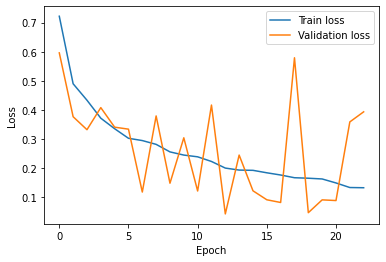

In [ ]:
import matplotlib.pyplot as plt

# Plot of Loss
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train loss', 'Validation loss'])


Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Accuracy')

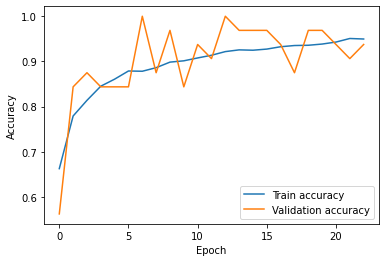

In [ ]:

# Plot of Accuracy
plt.plot(trained_model.history['accuracy'])
plt.plot(trained_model.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train accuracy', 'Validation accuracy'])

# Prediction

In [ ]:
test_dir = "/content/drive/My Drive/Kaggle_1/MaskDataset/test_images/"

In [ ]:
test_gen = test_data_gen.flow_from_directory(test_dir,
                                             batch_size=8, 
                                             target_size=(img_size, img_size),
                                             class_mode='categorical',
                                             shuffle=False,
                                             seed=SEED)

test_dataset = tf.data.Dataset.from_generator(lambda: test_gen,
                                              output_types=(tf.float32, tf.float32),
                                              output_shapes=([None, img_size, img_size, 3], None))

Found 450 images belonging to 1 classes.


In [ ]:
eval_out = model.predict(x=test_dataset,
                          steps=len(test_gen),
                          verbose=0)
eval_out

array([[7.5055236e-01, 2.8039768e-04, 2.4916720e-01],
       [8.9915417e-08, 1.2645985e-04, 9.9987340e-01],
       [9.9801385e-01, 3.9226165e-05, 1.9468344e-03],
       ...,
       [1.8486811e-04, 2.7459974e-03, 9.9706918e-01],
       [2.5020361e-05, 9.7972900e-01, 2.0246044e-02],
       [1.4409330e-01, 7.2153694e-06, 8.5589951e-01]], dtype=float32)

In [ ]:
label_map = (train_gen.class_indices)


map_cat = {v: k for k, v in label_map.items()}


real_names = {v: k for k, v in classes_names.items()}


results = {}
for i,name in enumerate(test_gen.filenames):
  real_name = name.split("/")[1]
  category = map_cat[np.argmax(eval_out[i])]
  results[real_name] = real_names[category]

# Csv generation for Kaggle

In [ ]:
#Kaggle Result

import os
from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [ ]:
create_csv(results,"/content/drive/My Drive/Keras3")